
# xView2 Challenge Dataset 
## Exploratory Data Analysis

### About

This notebook reads the processed dataset of labels and conducts an EDA on the labels and images. A separate map link is made available for exploring the data interactively. 

### Data
| **Name** | **Type** | **Location Type** | **Description** | **Location** | 
| --- | --- | --- | --- | --- | 
| `full_challenge_data` | `input` | `S3` | Read the transformed label data from S3 after processing through ingestion | `s3://BUCKET/datasets/xview2/processed/full_challenge_data.parquet` | 

### Compute Resources

32 GB RAM, 4 cores

### Last Updated
`Feb 11, 2024`

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from smart_open import open
from PIL import Image
from io import BytesIO
import inflection
from typing import Literal

from src.utils.config import S3_BUCKET

In [0]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_rows", 10_000_000)

sns.set_theme()


### Read Preprocessed Label Data

The dataset contains all of `train`, `test` and `holdout` records in a single file. It also contains image names of the respective records, which has to be prefixed with the location either locally or S3, so that they can be read by the notebook.

Example: 
* S3: `IMG_01.png` -> `s3://BUCKET/datasets/xview2/challenge/train/images/IMG_01.png` or;
* Local: `IMG_01.png` -> `./train/images/IMG_01.png`

> The dataset is at a per-train/test, per-building level. 


#### Primary Fields

* `id` refers to an individual image - unique to a pre-image and a post-image as having separate IDs
* `image_id` column refers to all data related to a single image - both pre-and-post image will have the same `image_id`
* `building_id` column refers to the the data for a building. One `id` or `image_id` can have many `building_id`
* `*_polygon` columns refer to the vertices of the polygon / shape in `wkt` format of the building when plotted on: 
  * `map_polygon`: a world map. They're set to `WGS:84` projection
  * `image_polygon`: the satellite image of resolution `width` x `height`

In [0]:
DATA_URL: str = f"s3://{S3_BUCKET}/datasets/xview2/processed/full_challenge_data.parquet"
print(DATA_URL)

s3://alivio/datasets/xview2/processed/full_challenge_data.parquet


In [0]:
df: pd.DataFrame = pd.read_parquet(DATA_URL)

print(df.shape)
df.head()

(545816, 27)


,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,catalog_id,original_width,original_height,width,height,id,img_name,map_polygon,building_id,image_polygon,feature_type,damage,dataset,image_id,is_pre_image,is_post_image
0,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,104001003E575F00,1024,1024,1024,1024,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83554484998086 14.43845885230631...,88703461-a33d-4327-9244-a0d4e2242ede,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
1,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,104001003E575F00,1024,1024,1024,1024,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83658244456636 14.43748886352666...,e168e405-3479-44ee-849a-7af2ed32dee1,"POLYGON ((226.8267143191367 307.8635026276182,...",building,destroyed,test,guatemala-volcano_00000003,False,True
2,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,104001003E575F00,1024,1024,1024,1024,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83487803042956 14.43776515972186...,9f8f8916-b6c5-4fa8-ab64-c8fd86eca035,"POLYGON ((601.0923397346356 241.9779197994199,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
3,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,flooding,10500100123A5000,1024,1024,1024,1024,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05237408501472 33.58644838741007...,624f417b-fd9f-4544-ba25-9ba2be361d27,POLYGON ((43.56144524808627 0.0045224975870225...,building,no-damage,test,hurricane-florence_00000005,False,True
4,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,flooding,10500100123A5000,1024,1024,1024,1024,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05057793741786 33.58642007435035...,557fbd1d-68bf-4776-a1a5-9bbd45cda227,POLYGON ((406.9497321265795 0.0095005985733089...,building,no-damage,test,hurricane-florence_00000005,False,True


We can see that `dataset`, `id` and `building_id` together make up all unique rows of the data. We also make some other assertions on the integrity of the dataset

In [0]:
assert (
    df.drop_duplicates(subset=["dataset", "id", "building_id"]).shape == df.shape
), "Data contains duplicates"

assert (
    df.groupby(["image_id"])["dataset"].nunique().max() == 1
), "Same image appears in two or more of train/test/validation sets"

assert (
    df.groupby(["image_id"])["id"].nunique().max() == 2
), "One or more images has more than a pair of pre-and-post images"

assert (
    df.groupby(["building_id"])["dataset"].nunique().max() == 1
), "Same building appears in two or more of train/test/validation sets"

### Basic Inspection

Here, we see that a single ID has many building IDs and verify that the image contains said building IDs, with pre-and-post data

In [0]:
sample_df: pd.DataFrame = df[
    df.image_id == "guatemala-volcano_00000003"
].drop_duplicates(subset=["id"])

print(sample_df.shape)
sample_df

(2, 27)


,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,catalog_id,original_width,original_height,width,height,id,img_name,map_polygon,building_id,image_polygon,feature_type,damage,dataset,image_id,is_pre_image,is_post_image
0,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.973360,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,volcano,104001003E575F00,1024,1024,1024,1024,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83554484998086 14.43845885230631...,88703461-a33d-4327-9244-a0d4e2242ede,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
206,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.345919,2018-02-05 17:10:18+00:00,17.933279,0.336265,150.807630,55.506645,118.24727,guatemala-volcano,volcano,10400100377A9B00,1024,1024,1024,1024,MjUxMzE2MQ.i3QvZXVyo2Sn-v3EcPzpMGJ0v90,guatemala-volcano_00000003_pre_disaster.png,"POLYGON ((-90.83554484997313 14.4384588523072,...",88703461-a33d-4327-9244-a0d4e2242ede,"POLYGON ((452.9629663894913 86.81005745416185,...",building,None,test,guatemala-volcano_00000003,True,False


In [0]:
def read_image_from_s3(
    img_name: str,
    dataset: str,
    minimize: bool = False,
) -> Image.Image:
    s3_path: str = (
        f"s3://{S3_BUCKET}/datasets/xview2/challenge/{dataset}/images/{img_name}"
    )
    with open(s3_path, "rb") as f:
        x = Image.open(BytesIO(f.read()))

    return x.resize((256, 256)) if minimize else x

In [0]:
def plot_images_from_metadataframe(
    dataframe: pd.DataFrame,
    path_col: str,
    subplot_rows: int,
    subplot_cols: int,
    title_cols: list[str] = None,
    figsize=(30, 9),
) -> plt.Figure:
    if subplot_rows * subplot_cols < len(dataframe):
        raise ValueError("Subplot matrix does not match size of dataframe")

    if path_col not in dataframe.columns:
        raise ValueError("Path column not found in dataframe")

    fig = plt.figure(figsize=figsize)

    for indx, row in dataframe.reset_index(drop=True).iterrows():
        img: Image.Image = read_image_from_s3(row.loc[path_col], row.loc["dataset"])
        fig.add_subplot(subplot_rows, subplot_cols, indx + 1)
        plt.imshow(img)
        plt.axis("off")
        if title_cols:
            title_str: str = ", ".join(
                [f"{inflection.humanize(c)}: {row.loc[c]}" for c in title_cols]
            )
            plt.title(title_str)

    return plt

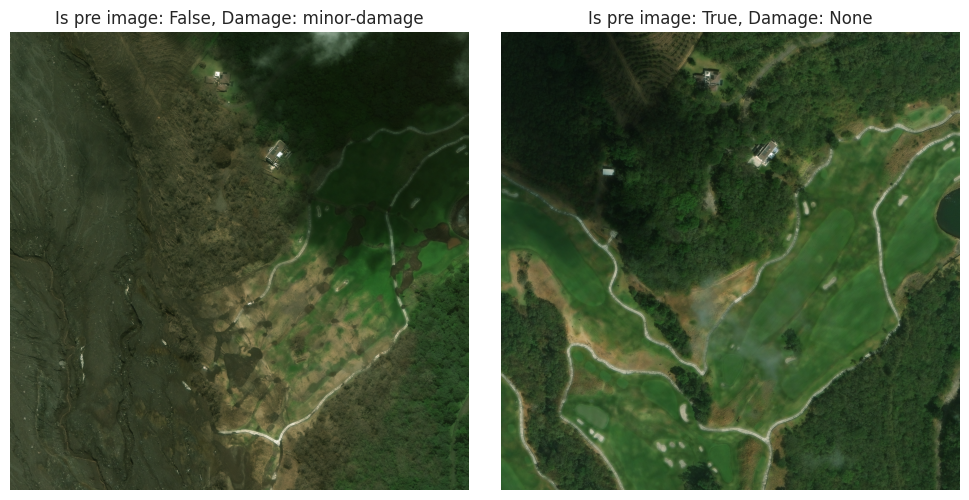

In [0]:
plt = plot_images_from_metadataframe(
    dataframe=sample_df,
    path_col="img_name",
    subplot_rows=1,
    subplot_cols=2,
    title_cols=["is_pre_image", "damage"],
    figsize=(10, 5),
)

plt.tight_layout()
plt.show()

### Summary Statistics

Total number of image pairs in data: 4665


<AxesSubplot: title={'center': 'Number of Unique Image Pairs per Dataset'}, ylabel='dataset'>

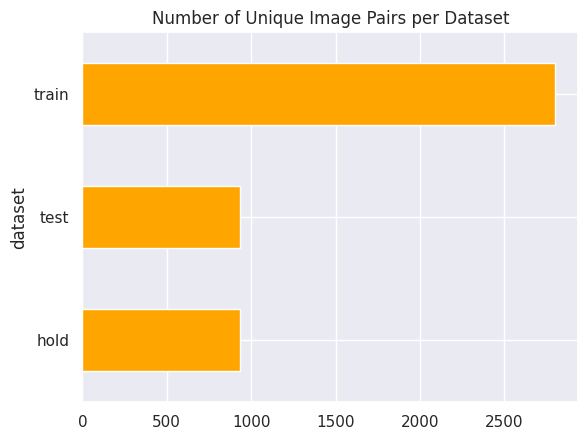

In [0]:
print("Total number of image pairs in data:", df["image_id"].nunique())

df.groupby(["dataset"])["image_id"].nunique().plot(
    kind="barh",
    title="Number of Unique Image Pairs per Dataset",
    grid=True,
    color="orange",
)

<AxesSubplot: title={'center': 'Distribution of Pre-and-Post images in datasets'}, ylabel='dataset'>

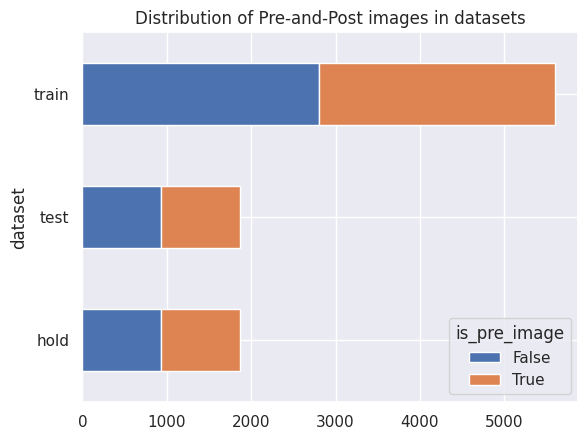

In [0]:


df_stacked: pd.DataFrame = (
    df.drop_duplicates(subset=["id", "is_pre_image"])[["dataset", "is_pre_image"]]
    .value_counts()
    .unstack()
)
df_stacked.plot(
    kind="barh",
    stacked=True,
    grid=True,
    title="Distribution of Pre-and-Post images in datasets",
)

Total number of buildings in data: 272041


<AxesSubplot: title={'center': 'Number of Buildings per Dataset'}, ylabel='dataset'>

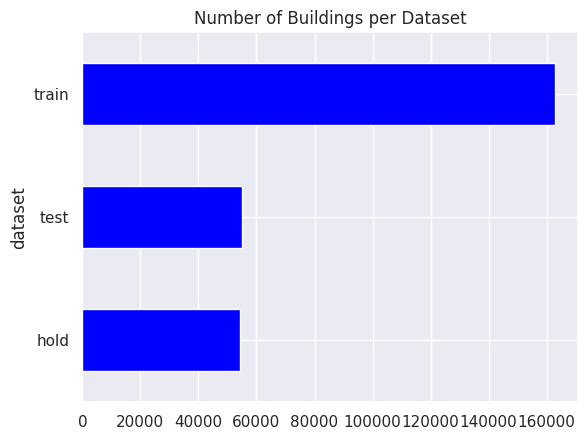

In [0]:
print("Total number of buildings in data:", df["building_id"].nunique())

df.groupby(["dataset"])["building_id"].nunique().plot(
    kind="barh",
    title="Number of Buildings per Dataset",
    grid=True,
    color="blue",
)